In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
import os
import glob
import random
from shutil import copyfile
import itertools

In [32]:
path = 'img/'
file_name = "img_meta.csv"
ts = 0.25

## Train Test Valid Split

In [52]:
df = pd.read_csv(file_name)
df.drop(df[df['dataset'] != 'HAM10000'].index, inplace=True)
df.reset_index(inplace=True)
df.drop(['diagnosis_another', 'Unnamed: 11', 'index'], axis=1, inplace=True)
df

,id,name,type,w,h,dataset,diagnosis,diagnosis_confirm_type,age,sex
0,5aaf12491165976913627e89,ISIC_0024306,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,45,male
1,5aaf12491165976913627e95,ISIC_0024307,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,50,male
2,5aaf12491165976913627ea0,ISIC_0024308,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,55,female
3,5aaf12491165976913627eab,ISIC_0024309,dermoscopic,600,450,HAM10000,nevus,serial imaging showing no change,40,male
4,5aaf12491165976913627eb6,ISIC_0024310,dermoscopic,600,450,HAM10000,melanoma,histopathology,60,male
...,...,...,...,...,...,...,...,...,...,...
10010,5aaf162711659769136471f0,ISIC_0034316,dermoscopic,600,450,HAM10000,melanoma,histopathology,85,male
10011,5aaf162711659769136471fb,ISIC_0034317,dermoscopic,600,450,HAM10000,melanoma,histopathology,70,female
10012,5aaf16271165976913647206,ISIC_0034318,dermoscopic,600,450,HAM10000,pigmented benign keratosis,histopathology,55,male
10013,5aaf16271165976913647214,ISIC_0034319,dermoscopic,600,450,HAM10000,nevus,histopathology,30,male


In [53]:
class_names = list(df["diagnosis"].unique())
class_names

['nevus',
 'melanoma',
 'pigmented benign keratosis',
 'dermatofibroma',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'vascular lesion',
 'actinic keratosis']

In [33]:
X = df['name']
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=ts, random_state=42)

In [19]:
def plot_hist(data, name=""):
    plt.figure(figsize=(16,5))
    plt.xticks(rotation=45)
    plt.title(name)
    sns.countplot(data);   

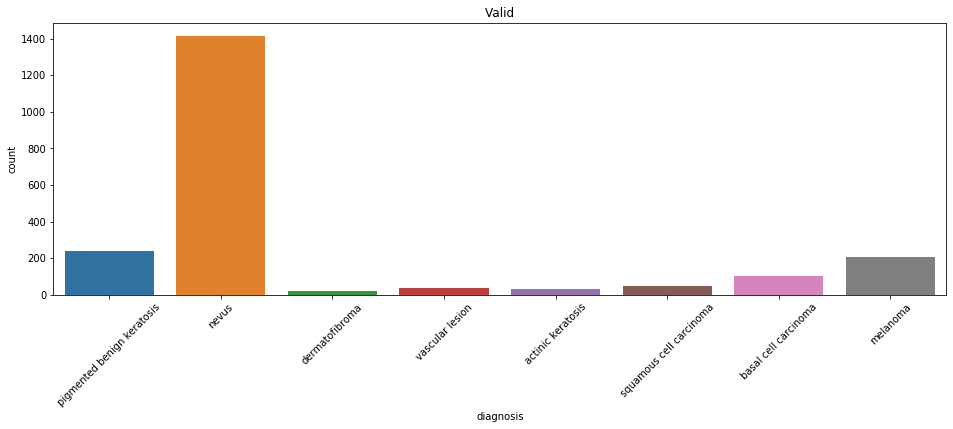

In [23]:
plot_hist(y_valid, "Valid")

In [36]:
X_train = list(X_train)
X_test = list(X_test)
X_valid = list(X_valid)

In [41]:
for i, name in tqdm_notebook(enumerate(X)):
    mode = "train"
    if name in X_test:
        mode = "test"
    elif name in X_valid:
        mode = "valid"
    
    old_path = path + f"{name}.jpg"
    new_dir = path + f"{mode}/{y[i]}/"
    new_path = new_dir + f"{name}.jpg"
    
    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)
    if os.path.isfile(old_path):
        os.replace(old_path, new_path)

In [59]:
def get_segment_stat(root_path, class_names):
    stat_dict = {'class_name' : class_names, "train" : [], "test" : [], "valid" : []}
    
    for mode in os.listdir(root_path):
        if os.path.isdir(os.path.join(root_path, mode)):
            for cl in class_names:
                stat_dict[mode].append(len(glob.glob(f"{root_path}/{mode}/{cl}/*.jpg")))

    stat_df = pd.DataFrame(stat_dict)
    stat_df["all"] = stat_df["train"] + stat_df["test"] + stat_df["valid"]
#     stat_df = stat_df.set_index("class_name")
    return stat_df

In [61]:
stdf = get_segment_stat("img/", class_names)
stdf

,class_name,train,test,valid,all
0,nevus,3760,1673,1272,6705
1,melanoma,608,303,202,1113
2,pigmented benign keratosis,632,259,208,1099
3,dermatofibroma,65,28,22,115
4,squamous cell carcinoma,120,47,30,197
5,basal cell carcinoma,297,127,90,514
6,vascular lesion,80,37,25,142
7,actinic keratosis,71,30,29,130


## Разбиение выборки на равные части (по минимуму)

In [62]:
lim = stdf["train"].min()
lim

65

In [64]:
for cl in class_names:
    train_folder = f"img/train_{lim}/" + cl
    if not os.path.isdir(train_folder):
        os.makedirs(train_folder)

In [67]:
train_fn = f"img/train"
print(train_fn)
for clname in os.listdir(train_fn):
    img_names = os.listdir(f"{train_fn}\\{clname}\\")
    random.shuffle(img_names)
    selected_names = img_names[:lim]
    print(clname, len(selected_names), "/", len(img_names))
    for name in selected_names:
        old_path = f"{train_fn}\\{clname}\\{name}"
        new_path = f"{train_fn}_{lim}\\{clname}\\{name}"
        copyfile(old_path, new_path)

img/train
actinic keratosis 65 / 71
basal cell carcinoma 65 / 297
dermatofibroma 65 / 65
melanoma 65 / 608
nevus 65 / 3760
pigmented benign keratosis 65 / 632
squamous cell carcinoma 65 / 120
vascular lesion 65 / 80


## Обогощение выборки до максимума 

In [3]:
path = "C:/Users/Dima/PyFiles/MedNN/img/train_enriched"
cl_names = os.listdir(path)

In [7]:
dataset = {}
for cl in cl_names:
    dataset[cl] = os.listdir(os.path.join(path, cl))

In [5]:
cnt = {}
for cl in cl_names:
    cnt[cl] = len(dataset[cl])

In [6]:
max_cnt = max([v for v in cnt.values()])

In [7]:
add = {}
for cl in cl_names:
    add[cl] = max_cnt - cnt[cl]

In [8]:
def transform(newPth, oldPth):
    img = Image.open(oldPth)
    deg = random.randint(-45, 45)
    hf = bool(random.randint(0,1))
    vf = bool(random.randint(0,1))
    img = img.rotate(deg)
    if hf:
        img = ImageOps.mirror(img)
    if vf:
        img = ImageOps.flip(img)
    img.save(newPth)

In [9]:
for cl in cl_names:
    iters = int(add[cl] / cnt[cl])
    remain = add[cl] - cnt[cl] * iters
    
    for i in range(iters):
        for name in dataset[cl]:
            oldPth = path + '/' + cl + '/' + name
            newPth = path + '/' + cl + '/' + f"{i}_{name}"
            transform(newPth, oldPth)
            
    orig_names = dataset[cl]
    
    for j in range(remain):
        oldPth = path + '/' + cl + '/' + orig_names[j]
        newPth = path + '/' + cl + '/' + f"{i}-{orig_names[j]}"
        transform(newPth, oldPth)

In [5]:
for cl in cl_names:
    print(cl, ':', len(os.listdir(os.path.join(path, cl))))

actinic keratosis : 4479
basal cell carcinoma : 4479
dermatofibroma : 4479
melanoma : 4479
nevus : 4479
pigmented benign keratosis : 4479
squamous cell carcinoma : 4479
vascular lesion : 4479


In [12]:
def grouper(n, iterable):
    it = iter(iterable)
    while True:
       chunk = tuple(itertools.islice(it, n))
       if not chunk:
           return
       yield chunk

In [ ]:
for gr in grouper(122, dataset['actinic keratosis']):
    for g in gr:
        print(g)